# Serial correlation

In [ ]:
library(here)
library(haven)
library(sdazar)
library(ggplot2)
library(brms)
options(mc.cores = parallel::detectCores())
library(imputeTS)
options(repr.plot.width = 5, repr.plot.height = 3)
library(texreg)
# library(stringr)
# library(ggridges)
# library(patchwork)

In [3]:
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia",
                   "Costa_Rica", "Cuba", "Dominican_Republic", "Ecuador",
                   "El_Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua",
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

df[, ctry := factor(ctry, labels=country_labels)]

head(df)

In [3]:
# select covarites
covariates = names(df)[10:28]

c = df[tseries2==1 & age==0 & year>=1900, lapply(.SD,Max),
       .SDcols=covariates, by=.(ctry, year)]

le = df[tseries2==1 & age==0 & year>=1900, .(Ex=Mean(Ex)), by=.(ctry, year)]

# check
(nrow(c) + nrow(le))/2

dt = merge(c, le, by=c('ctry', 'year'))

# missing data
print(countmis(dt))

In [3]:
# define dataset

test = dt[year>=1900, .(ctry, year, gdp_pc, urban, lit, Ex, water, sewage, elec, us_aid, tfr)]

# periods
test[year<1950, gyear:='1950']
test[year>=1950 & year<1970, gyear:='1950-1969']
test[year>=1970 & year<1990, gyear:='1970-1989']
test[year>=1990, gyear :='1990']

# transform variable: weibull
test[, y := Ex/max(Ex+1.05), by = ctry] # adjustment is by country!
test[, wy := log(-log(1-y))]
max_le = test[, .(max_le = max(Ex+1.05)), by = ctry] # to recover values later
test[, ctry_year := paste0(ctry,'.', gyear)]

# define order
setorder(test, year)

# interpolation
test[, igdp_pc := na.interpolation(gdp_pc, option='stine'), by=ctry]
test[, iurban := na.interpolation(urban, option='stine'), by=ctry]
test[, ilit := na.interpolation(lit, option='stine'), by=ctry]
test[, itfr := na.interpolation(tfr, option='stine'), by=ctry]

test[, igdp_log := scale(log(igdp_pc), scale=FALSE, center=TRUE)]
test[, iurban_log := scale(log(iurban), scale=FALSE, center=TRUE)]
test[, ilit_log := scale(log(ilit), scale=FALSE, center=TRUE)]

# Filtering example: Chile

In [5]:
# filtering
chile = test[ctry=='Chile']

## Linear regression 

In [16]:
m1 = lm(wy ~ igdp_log, data=chile)

print(screenreg(m1))


             Model 1   
-----------------------
(Intercept)   -0.44 ***
              (0.03)   
igdp_log       1.30 ***
              (0.04)   
-----------------------
R^2            0.92    
Adj. R^2       0.92    
Num. obs.    111       
RMSE           0.20    
*** p < 0.001, ** p < 0.01, * p < 0.05


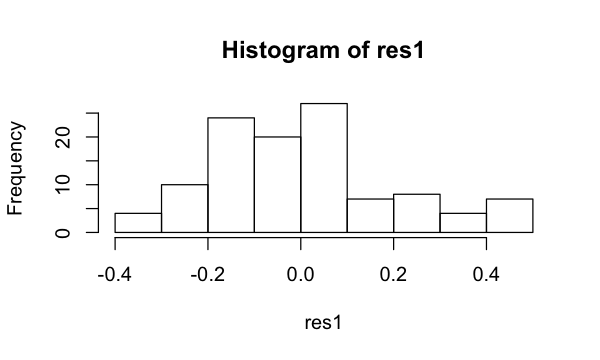

In [23]:
res1 = resid(m1)
hist(res1)

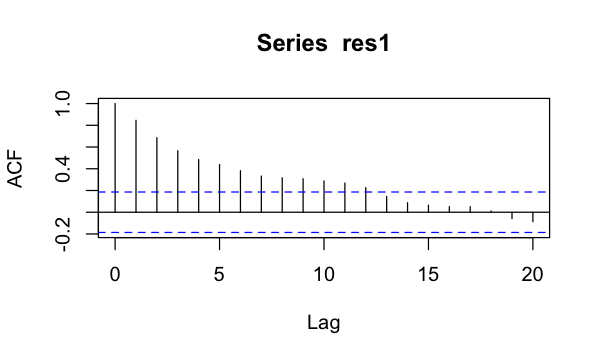

In [24]:
# autocorrelation
ac = acf(res1,pl=TRUE) # huge correlation first lag

This is clearly misspecification of the model. 

In [25]:
print(ac)


Autocorrelations of series ‘res1’, by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000  0.846  0.686  0.566  0.485  0.440  0.382  0.333  0.317  0.308  0.288 
    11     12     13     14     15     16     17     18     19     20 
 0.268  0.227  0.146  0.088  0.065  0.051  0.051  0.012 -0.058 -0.087 


In [26]:
r1 = 0.846 # assuming AR1

# compute lags
chile[, lag_igdp_log := shift(igdp_log)]
chile[, lag_wy := shift(wy)]

head(chile[, .(year, igdp_log, lag_igdp_log, wy, lag_wy)])

year,igdp_log,lag_igdp_log,wy,lag_wy
1900,-0.2174061,NA,-0.6831941,NA
1901,-0.2045084,-0.2174061,-0.6695660,-0.6831941
1902,-0.1734707,-0.2045084,-0.6652859,-0.6695660
1903,-0.2429097,-0.1734707,-0.6580972,-0.6652859
1904,-0.1756960,-0.2429097,-0.6508657,-0.6580972
1905,-0.1881189,-0.1756960,-0.6435910,-0.6508657


In [27]:
m1f =  lm(I(wy - r1*lag_wy) ~ I(igdp_log - r1*lag_igdp_log) , data = chile)

print(screenreg(m1f))


                                 Model 1   
-------------------------------------------
(Intercept)                       -0.02 *  
                                  (0.01)   
I(igdp_log - r1 * lag_igdp_log)    0.71 ***
                                  (0.07)   
-------------------------------------------
R^2                                0.49    
Adj. R^2                           0.48    
Num. obs.                        110       
RMSE                               0.08    
*** p < 0.001, ** p < 0.01, * p < 0.05


Coefficient changed!

In [28]:
res1f = resid(m1f)

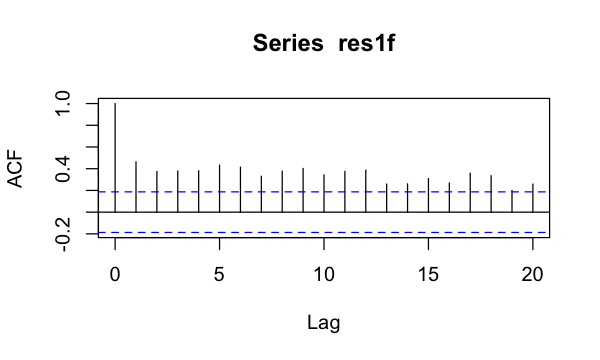

In [45]:
acf(res1f) # mis

Still signs of serial correlation. 

# Bayesian approach 

In [33]:
m2 = brm(formula = wy ~ 1 + igdp_log ,
          data = chile,
          iter = 2000,
          chains = 2)

summary(m2)

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log 
   Data: chile (Number of observations: 111) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 2000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.44      0.03    -0.49    -0.39       1528 1.00
igdp_log      1.30      0.04     1.23     1.37       1513 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.20      0.01     0.18     0.23       2000 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

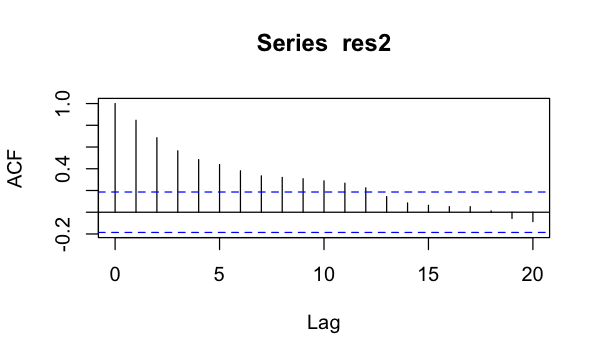

In [49]:
res2 = resid(m2, type = 'pearson')[, "Estimate"]
acf(res2) # similar pattern to frequentist approach but not exactly the same

In [47]:
m2f = brm(formula = wy ~ 1 + igdp_log,
          autocor = cor_arr(~ 1, r=1), # I am not sure how to reproduce frequentist model m1f
          data = chile,
          iter = 2000,
          chains = 2)

summary(m2f)

Compiling the C++ model
Start sampling


 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + igdp_log 
   Data: chile (Number of observations: 111) 
Samples: 2 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 2000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept    -0.04      0.02    -0.07    -0.01        960 1.00
igdp_log      0.15      0.04     0.07     0.23        786 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.07      0.00     0.06     0.08       1470 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).

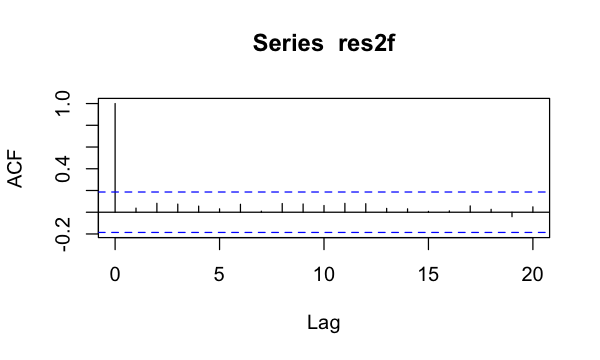

In [46]:
res2f = resid(m2f, type = 'pearson')[, "Estimate"]
acf(res2f)

No signs of serial correlation.